In [292]:
# Import libraries
import pandas as pd
import pandas_ta as ta
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from datetime import time
import seaborn as sns

In [293]:
timeframe = "M15"
symbols = ["SPX500"]
systems = ["Strat"]
starting_balance = 100
risk_per_trade = 0.02 # Risking 2% per trade

# Define times
timezone = "America/New_York"

spread_ratio = 0.0001 # Ratio of price

trailing = True
trailing_multiplier = 2.5

move_to_be = False

In [294]:
# Load CSV File
def get_price_data(symbol):
    df = pd.read_csv(f"../data/{symbol}_{timeframe}.csv", parse_dates=['Datetime'], index_col='Datetime')
    df.index = pd.to_datetime(df.index, utc=True).tz_convert(timezone)  # Keeps local timezone without converting to UTC
    return df

In [295]:
def calculate_inputs(df):
    df['EMA_200'] = ta.ema(df['Close'], length=200)
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
    df['RSI'] = ta.rsi(df['Close'], length=14)
    df['Range'] = df['High'] - df['Low']

    df['Bullish_Engulfing'] = ((df['Close'] > df['Open']) &  # Bullish current candle
                            (df['Open'].shift(1) > df['Close'].shift(1)) &  # Bearish previous candle
                            (df['Low'] <= df['Low'].shift(1)) &  # Current low is below the previous low
                            (df['High'] > df['High'].shift(1))  # Current high is above previous high
                            )
    return df

In [296]:
def generate_signals(df, s, atr_sl, tp_ratio):
    c1 = df['Close'] > df['EMA_200']
    c2 = df['RSI'] > 50
    c3 = df['Bullish_Engulfing']
    c4 = df['ATR'].notna()

    #generate entries and exits
    df[f"{s}_Signal"] = c1.shift(1) & c2.shift(1) & c3.shift(1) & c4.shift(1)

    # Generate exits 
    df['SL'] = df['Open'] - df['ATR'].shift(1) * atr_sl # ATR based stop
    #df['SL'] = df['Open'] - df['Range'].shift(1) * atr_sl # Original strategy stop
    stop_dist = df['Open'] - df['SL']
    if trailing:
        df['TP'] = df['Open'] + stop_dist * tp_ratio * 1000
    else:
        df['TP'] = df['Open'] + stop_dist * tp_ratio
    
    return df

In [297]:
def generate_trades(df, s, trail):
    #create empty list for trades
    trades_list = []
    trade_open = False
    balance = starting_balance
    equity = starting_balance
    balance_history = []
    equity_history = []

    # Extract numpy arrays for relevant columns
    open_prices = df['Open'].values
    high_prices = df['High'].values
    low_prices = df['Low'].values
    close_prices = df['Close'].values
    atr_values = df['ATR'].values if 'ATR' in df.columns else None
    sl_values = df['SL'].values
    tp_values = df['TP'].values
    signal_values = df[f"{s}_Signal"].values
    index_values = df.index

    
    #iterate through rows to work out entries and exits
    for i in range(len(df)):
        #if there is currently no trade
        if not trade_open:
            #check if long signal was generated and enter at the same time
            if signal_values[i]:
                entry_date = index_values[i]
                entry_price = open_prices[i]
                sl = sl_values[i]
                tp = tp_values[i]
                # Calculate position size based on risk percentage
                risk_amount = balance * risk_per_trade
                position_size = risk_amount / abs(entry_price - sl)  # Position size in units
                trade_open = True
        #check if a trade is already open
        if trade_open:
            #get price values
            low = low_prices[i]
            high = high_prices[i]

            # Calculate unrealized PnL
            floating_pnl = (high - entry_price) * position_size
            equity = balance + floating_pnl  # Update equity dynamically

            # Calculate unrealized PnL
            #check if stop is hit
            if low <= sl:
                #first check for a gap down
                exit_price = open_prices[i] if open_prices[i] <= sl else sl
                trade_open = False
            # Now do the same check for take profit
            elif high >= tp:
                #first check for a gap up
                exit_price = open_prices[i] if open_prices[i] >= tp else tp
                trade_open = False
            # Trail stop up
            elif trailing:
                new_stop = close_prices[i] - (atr_values[i] * trail)
                if new_stop > sl:
                    sl = new_stop
            # move stop to BE
            elif move_to_be:
                if high_prices[i] >= entry_price + (entry_price - sl):
                    sl = entry_price + 1  # e.g., buffer = 2 points

                        
            if not trade_open: # If trade has been closed
                exit_date = index_values[i]
                spread = exit_price * spread_ratio
                pnl = (exit_price - spread - entry_price) * position_size # PnL in currency terms
                balance += pnl  # Update balance with PnL

                #store trade data in a list
                trade = [entry_date, entry_price, exit_date, exit_price, position_size, pnl, balance, True]
                #append trade to overall trade list
                trades_list.append(trade)

        # Store balance and equity
        balance_history.append(balance)
        equity_history.append(equity)

    trades = pd.DataFrame(trades_list, columns=["Entry_Date", "Entry_Price", "Exit_Date", "Exit_Price", "Position_Size", "PnL", "Balance", "Sys_Trade"])
    
    #calculate return of each trade as well as the trade duration
    trades[f"{s}_Return"] = trades.Balance / trades.Balance.shift(1)

    #create a new dataframe with an index of exit dfs
    returns = pd.DataFrame(index=trades.Exit_Date)
    #create a new dataframe with an index of entries to track entry price
    entries = pd.DataFrame(index=trades.Entry_Date)

    entries[f"{s}_Entry_Price"] = pd.Series(trades.Entry_Price).values
    #add the Return column to this new data frame
    returns[f"{s}_Ret"] = pd.Series(trades[f"{s}_Return"]).values
    returns[f"{s}_Trade"] = pd.Series(trades.Sys_Trade).values
    returns[f"{s}_PnL"] = pd.Series(trades.PnL).values
    returns[f"{s}_Balance"] = pd.Series(trades.Balance).values

    #add the returns from the trades to the main data frame
    df = pd.concat([df, returns, entries], axis=1)
    #fill all the NaN return values with 1 as there was no profit or loss on those days
    df[f"{s}_Ret"] = df[f"{s}_Ret"].fillna(1)
    #fill all the NaN trade values with False as there was no trade on those days
    df[f"{s}_Trade"] = df[f"{s}_Trade"].infer_objects(copy=False)
    
    #use the updated balance and equity variables
    df[f"{s}_Bal"] = pd.Series(balance_history, index=df.index).ffill()
    df[f"{s}_Equity"] = pd.Series(equity_history, index=df.index).ffill()
    
    return df, trades

In [298]:
def backtest(price, atr_sl, tp_ratio, trail):
    #calculate strategy inputs
    price = calculate_inputs(price)

    for s in systems:
        #generate signals
        price = generate_signals(price, s, atr_sl, tp_ratio)

        #generate trades
        price, trades = generate_trades(price, s, trail)

    for s in systems:
        #calculate drawdown
        price[f"{s}_Peak"] = price[f"{s}_Bal"].cummax()
        price[f"{s}_DD"] = price[f"{s}_Bal"] - price[f"{s}_Peak"]

    return price, trades

In [299]:
results = []
prog = 0
sl_range = np.arange(1.5, 2.0, 0.5)
tp_range = np.arange(1.0, 1.5, 0.5)
trail_range = np.arange(2.5, 3, 0.5)
max_prog = len(symbols) * len(sl_range) * len(tp_range) * len(trail_range)
for sym in symbols:
    price = get_price_data(sym)
    for atr_sl in sl_range:
        for tp_ratio in tp_range:
            for trail in trail_range:
                result, trades = backtest(price, atr_sl, tp_ratio, trail)
                results.append(result)
                prog += 1
                clear_output(wait=True)
                print(f"Progress: {round((prog / max_prog) * 100)} %")

Progress: 100 %


In [300]:
def get_metrics(system, data):
    metrics = {}
    years = (data.index[-1] - data.index[0]).days / 365.25
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
 
    win = data[f"{system}_Ret"] > 1
    loss = data[f"{system}_Ret"] < 1
    trades_triggered = data[f"{system}_Trade"].sum()
    wins = win.sum()
    losses = loss.sum()
    winrate = round(wins / (wins + losses) * 100, 2)
    
    # calculate the size of the move from the entry data to the close
    avg_up_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] > 1].mean() - 1) * 100
    avg_down_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] < 1].mean() - 1) * 100
    avg_rr = round(abs(avg_up_move / avg_down_move), 2)

    #save data
    metrics["Start_Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final_Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    #metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual_Return"] = round(sys_cagr, 2)
    metrics["Max_Drawdown"] = round(sys_dd, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    metrics["Winrate"] = round(winrate, 2)
    metrics["Avg_RR"] = avg_rr

    return metrics

In [301]:
for count, res in enumerate(results):
    sys_metrics = {}
    for s in systems:
        sys_metrics.update({s: get_metrics(s, res)})
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)

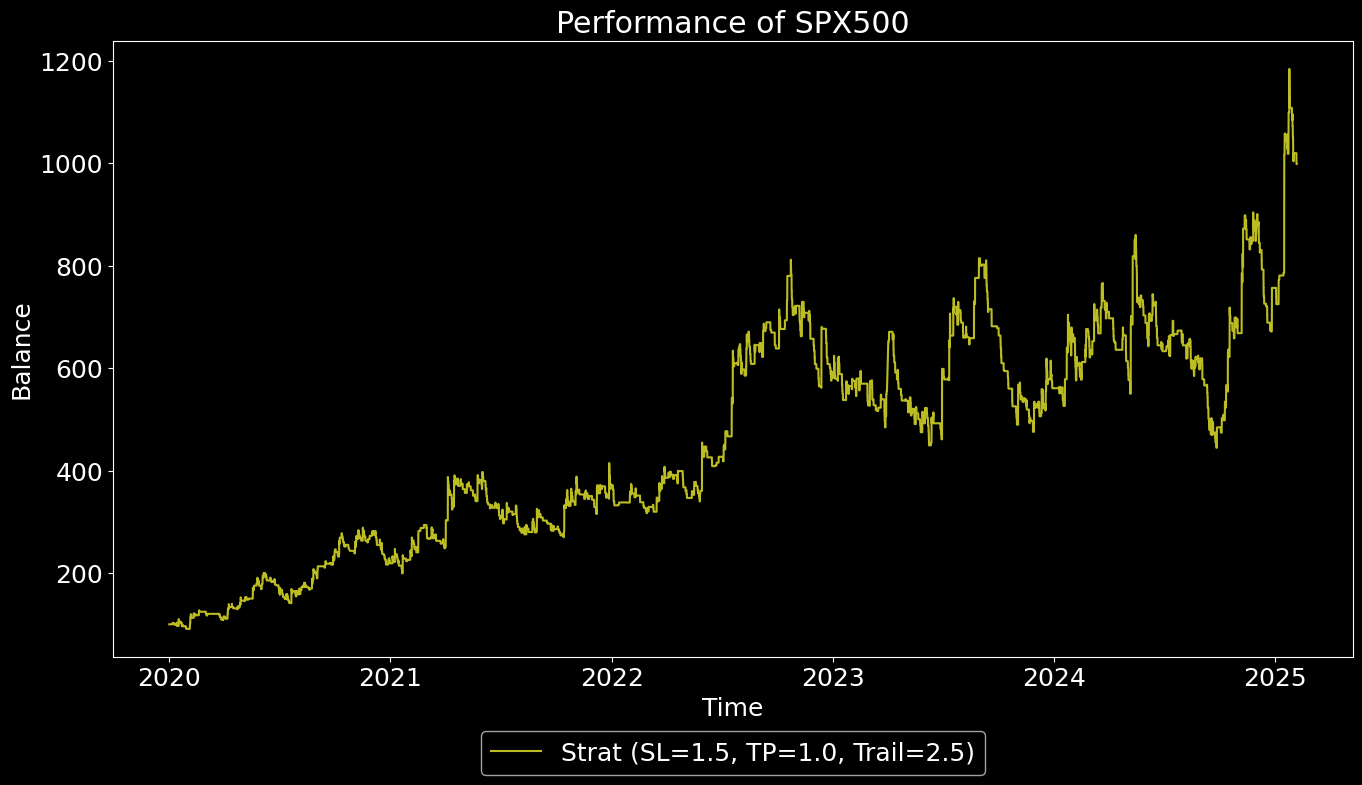

In [302]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({"font.size": 18})

colours = ["tab:olive", "tab:blue", "tab:purple", "tab:orange", "tab:green", "tab:cyan", "tab:red", "tab:gray", "tab:pink"]

for count, sym in enumerate(symbols):
    fig, ax = plt.subplots()
    ax.set_title(f"Performance of {sym}")

    legend_entries = []  # Store legend labels
    colour_idx = 0  # To cycle through colors if needed

    for atr_sl in sl_range:
        for tp_ratio in tp_range:
            for trail in trail_range:
                for c, s in enumerate(systems):
                    # Generate a unique index for each (SL, TP) combination
                    result_idx = (
                        count * len(sl_range) * len(tp_range) * len(trail_range)
                        + list(sl_range).index(atr_sl) * len(tp_range) * len(trail_range)
                        + list(tp_range).index(tp_ratio) * len(trail_range)
                        + list(trail_range).index(trail)
                    )

                    if result_idx >= len(results):  
                        continue  # Prevent out-of-bounds error

                    label = f"{s} (SL={atr_sl}, TP={tp_ratio}, Trail={trail})"
                    color = colours[colour_idx % len(colours)]  # Cycle through colors
                    
                    df_result = results[result_idx]
                    if f"{s}_Bal" not in df_result:
                        continue

                    y = df_result[f"{s}_Bal"]
                    x = df_result.index

                    ax.plot(x, y, color=color, label=label)
                    legend_entries.append(label)

                    colour_idx += 1  # Move to next color

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.xlabel("Time")
    plt.ylabel("Balance")
    #plt.grid(True, linestyle="--", alpha=0.5)    
    plt.savefig(f"plot_{timeframe}.png", format="png", dpi=300, bbox_inches="tight")
    plt.show()
    

In [303]:
print(sys_metrics_df)

                 Strat
Start_Balance   100.00
Final_Balance   998.68
Annual_Return    57.09
Max_Drawdown    -48.31
Trades         1384.00
Winrate          33.12
Avg_RR            2.43


In [304]:
# Split index into 'Date' and 'Time' columns
trades['Entry_Date'] = pd.to_datetime(trades["Entry_Date"])
trades['Entry_Hour'] = trades['Entry_Date'].dt.hour

# Convert "Strat_Breakout_Return" to percentage
trades["Return_Percentage"] = (trades[f"{systems[-1]}_Return"] - 1) * 100

# Group by Hour and Calculate Average PnL
hourly_return = trades.groupby("Entry_Hour")["Return_Percentage"].mean()

# Group by Hour and Count Number of Trades
hourly_trades_count = trades.groupby("Entry_Hour")["Return_Percentage"].count()

# Combine the two results into a single DataFrame
hourly_stats = pd.DataFrame({
    "Average_Return_Percentage": hourly_return,
    "Trades_Count": hourly_trades_count
})

# Display Result
print(hourly_stats)

            Average_Return_Percentage  Trades_Count
Entry_Hour                                         
0                           -0.059852            41
1                            1.169130            53
2                           -0.717624            50
3                            0.449938            82
4                            1.345223            48
5                            0.915808            51
6                           -0.383756            59
7                           -0.023118            74
8                            0.753498            99
9                           -0.304894           120
10                           0.548481            46
11                           0.175751            61
12                           0.410077            61
13                           0.516954            76
14                           0.508694            82
15                          -0.145511            64
16                           0.391208            66
18          

In [305]:
trades.to_csv("trades.csv")
result.to_csv("result.csv")

In [306]:
# Extract unique years
years = result.index.year.unique()

# Calculate returns
data = []
for year in result.index.year.unique():
    yearly_data = result[result.index.year == year]
    
    for system in systems:
        start_bal = yearly_data[f"{system}_Bal"].iloc[0]
        end_bal = yearly_data[f"{system}_Bal"].iloc[-1]
        return_pct = ((end_bal - start_bal) / start_bal) * 100
        data.append([year, system, return_pct])

# Convert to DataFrame
returns_df = pd.DataFrame(data, columns=["Year", "System", "Return"])



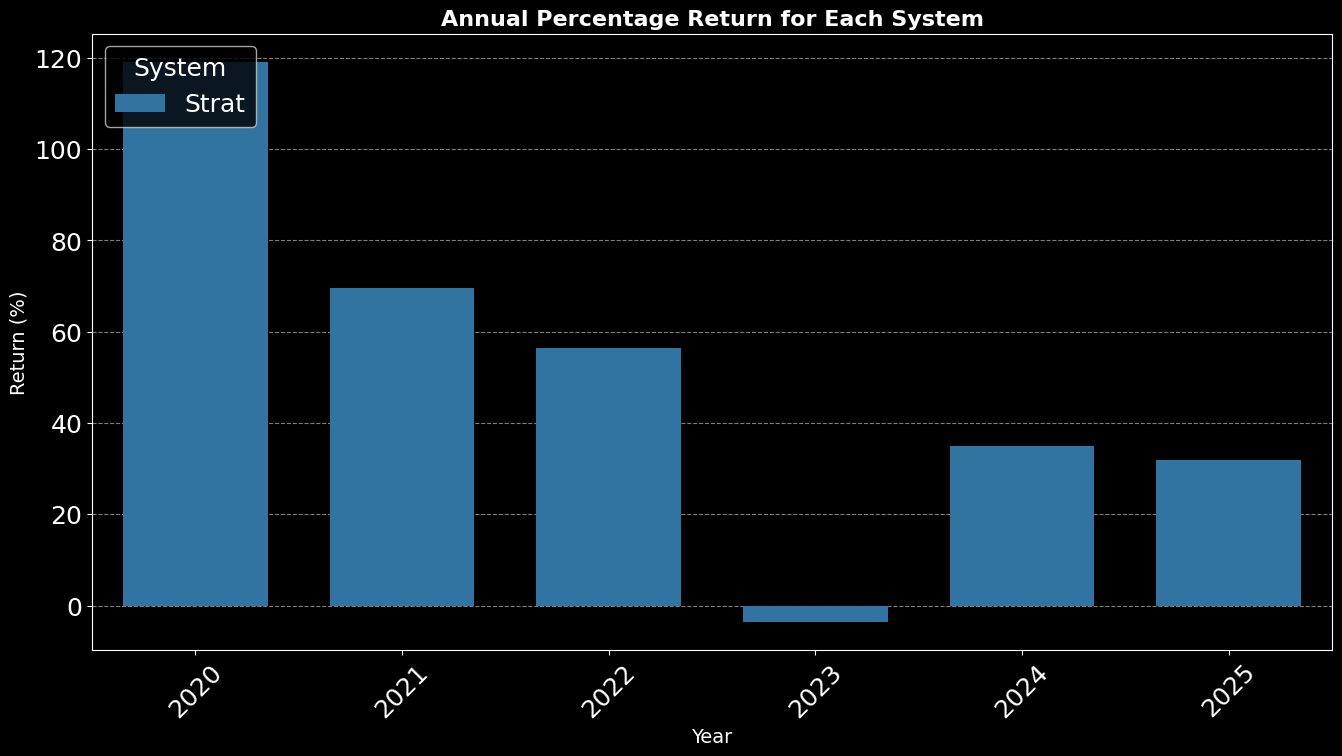

In [307]:
# Set up the figure
plt.figure(figsize=(16, 8))
sns.set_palette("tab10")

# Plot the bar chart
ax = sns.barplot(data=returns_df, x="Year", y="Return", hue="System", dodge=True, width=0.7)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add title and labels
plt.ylabel("Return (%)", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.title("Annual Percentage Return for Each System", fontsize=16, fontweight='bold')

# Gridlines
ax.set_axisbelow(True)
plt.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)

# Legend
plt.legend(title="System", loc="upper left")

# Show the final chart
plt.show()
